# Income Prediction from Census Data

## Summary
This report presents an analysis of the [Census Income dataset](https://archive.ics.uci.edu/dataset/2/adult), predicting whether individuals in the US earn above or below $50,000 annually (1994 pricing, adjusting for inflation, this income is equivalent to $110,000 in 2025). The analysis encompasses data cleaning, exploratory analysis, feature engineering, model development, and evaluation, culminating in a comparison of Generalized Linear Model (GLM) and Gradient Boosting Machine (GBM) approaches.

### Key Results:
- Final Models: LGBM achieved the highest accuracy, with 87.4% cross-validated accuracy. However, despite much simpler, GLM still achieved good accuracy, with 84.5%, and may be the best model of the two depending on business case.

- Top 5 Predictive Features (LGBM):
    - Capital Net: Investment income indicator
    - Age: Life-cycle earnings pattern
    - Hours per Week: Full-time vs part-time distinction
    - Education: Human capital investment
    - Relationship = Married: Household income dynamics

## Motivation for the Prediction Task

Accurately predicting individual income levels has significant practical applications across multiple sectors. For example:

**Government & Public Policy:**
- **Welfare Eligibility Screening:** In countries lacking centralized income tracking (e.g., UK), predictive models can help identify individuals likely eligible for means-tested benefits (Winter Fuel Payment, Universal Credit) without intrusive income verification.

**Non-Profit Sector:**
- **Donor Prospecting:** Charities often use crude proxies (e.g., age, postcode) for wealth assessment during door-to-door fundraising. Data-driven income prediction can improve targeting efficiency, reducing wasted outreach while respecting privacy.

**Privacy Consideration:** This approach offers an alternative to directly collecting sensitive income data, this may give an edge to sertain businesses.

## Exploratory Data Analysis

### Dataset Overview
The Census Income dataset from the UCI Machine Learning Repository contains demographic and employment information extracted from the 1994 US Census. The prediction task is to determine whether an individual's income exceeds $50,000 per year.

**Dataset Characteristics**:
- Samples: 48,842 individuals
- Original Features: 15 variables
- Target Variable: Binary income classification (<=50K, >50K)
- Source: US Census Bureau, 1994

**Distribution**:

Not all numerical columns distribute similarly. While age shows a relatively smooth spread, hours-per-week is highly concentrated with a single value (40 hours) representing 46.7% of the dataset. This concentration makes sense, as 40 hours is the standard full-time employment, whereas age varies naturally across the population. Understanding these distribution patterns is essential for appropriate statistical analysis and modelling decisions. The chart below highlights the diversity in distribution.

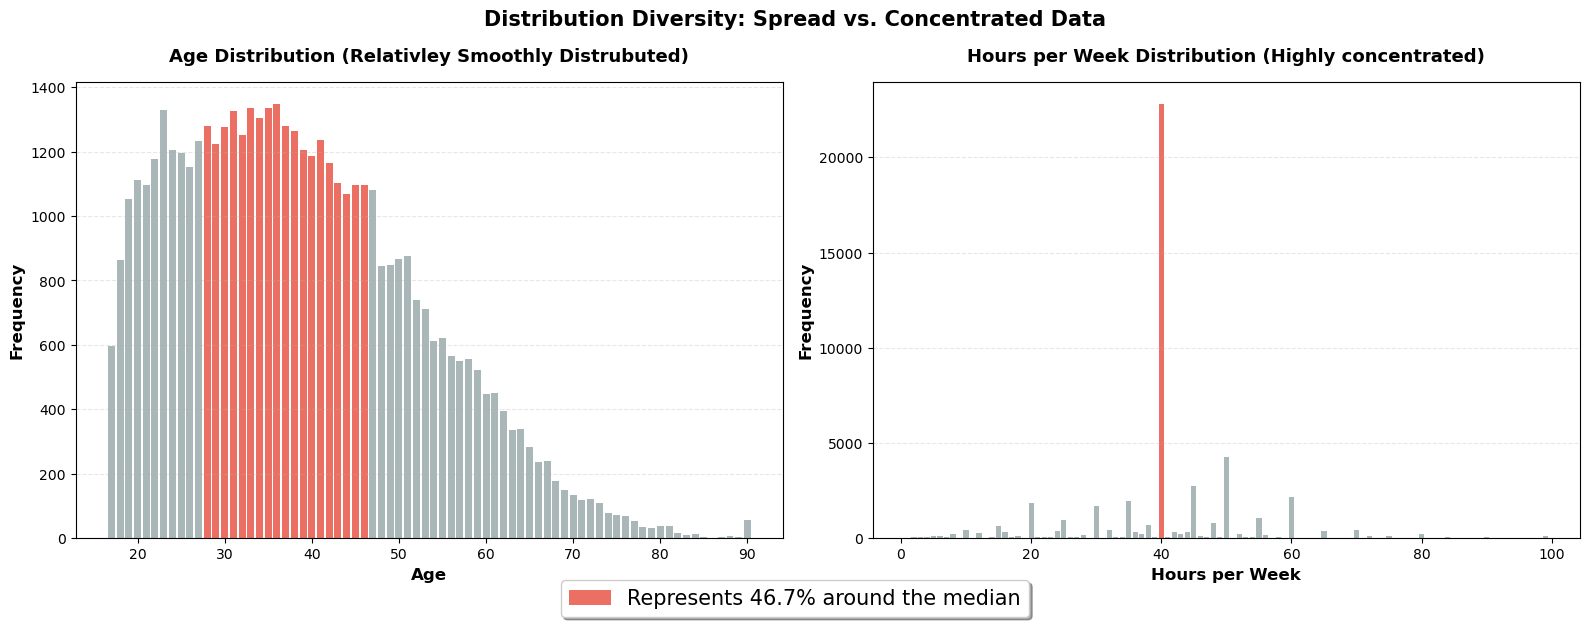

In [1]:
import pandas as pd
from pathlib import Path
import sys

current_dir = Path.cwd()
src_directory = current_dir.parent
sys.path.append(str(src_directory))

from notebooks.visualisations import display_dataset, distribution_variety

parquet_path = src_directory / "data" / "census_income.parquet"

df_raw = pd.read_parquet(parquet_path)

distribution_variety.distribution_variety(df_raw)

### Initial Data Quality Assessment

There were a number of minor data quality issues with the dataset, many of which could be resolved by simple transformations of the dataset. Below I visualise some of the data quality problems that needed to be dealt with.

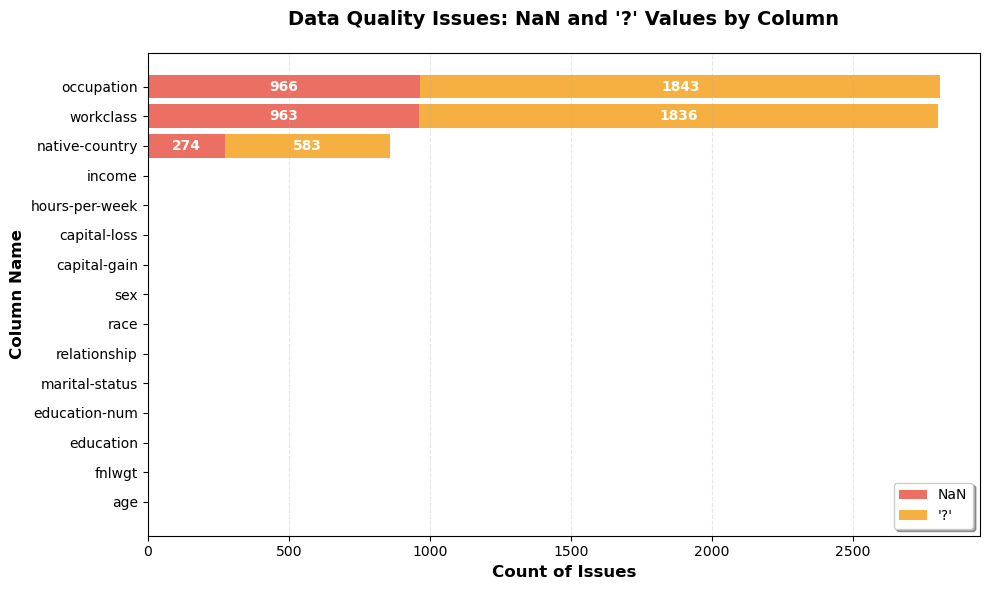

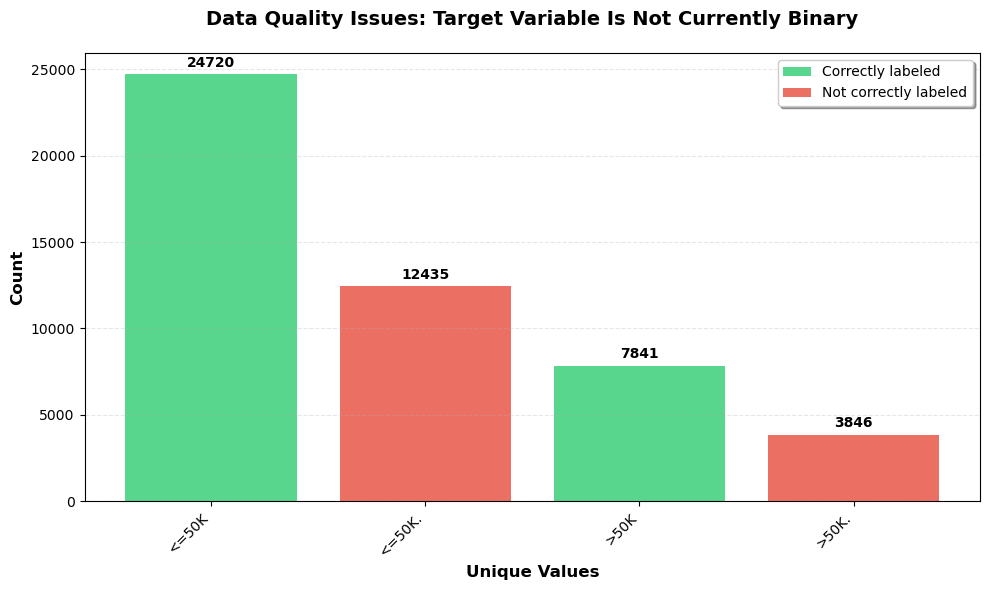

In [2]:
from notebooks.visualisations import visualize_missing_data, binary_column_issue

visualize_missing_data.visualize_missing_data(df_raw)
binary_column_issue.binary_column_issue(df_raw, 'income', expected_values=['<=50K', '>50K'])

#### Cleaning Pipeline

Below I list all cleaning steps taken:
- Add unique ID column (there were 29 duplicates, this isn't unexpected as some people will have the same demographics. Adding unique ID allows us to tell these individuals apart)
- Clean column names (e.g. 'capital-gain' -> 'capital_gain')
- Remove seemingly redundant columns ('fnlwgt', 'education-num')
- Clean income data (there were some values with a '.' at the end e.g. '>50K.') 
- Binarize income data (1 for '>50K', 0 for '<=50K') and rename to 'high_income'
- Binarize sex and rename to is_female (1 for 'Female, 0 for 'Male')
- Binarize race into two columns, is_white and is_black
- Replace '?' values with pandas NaN
- Trim whitespace from all string values
- Order and transform 'education' column. Change datatype from str to int (e.g. 'Preschool' = 1 < '1st-4th' = 2 < ... < 'Doctorate' = 16)
- Transform capital-gain and capital-loss into a single column capital_net
- Relationship field was slightly simplified, bundling 'Wife' and 'Husband' into one value, 'Married'

All cleaning steps were split modularly into their own functions in the file cleaning.py. They can be run together using the full_clean function in cleaning.py.

In [3]:
from income_predict import cleaning

df_clean = cleaning.full_clean(df_raw)

## Feature Selection & Engineering

### Feature Selection
The rational was largely based on intuition and prior literature, though some simple exploratory analysis was also used to confirm such theories.

#### Numeric Features:
- **age** (Strong non-linear association with income (see visualisation below))
- **education** (With the ordinal encoding)
- **capital_net**
- **hours_per_week**
- **is_female**
- **is_white**
- **is_black**

#### Categorical Features:
- **work_class**
- **occupation**
- **relationship**
- **native_country**

#### Features Excluded and Why:
- **fnlwgt**: Sampling weight for census data, not predictive of individual income
- **education-num**: Redundant with categorical education (now ordinal education)
- **marital_status**: Excluded to avoid multicollinearity with relationship
- **capital_gain / capital_loss**: Combined into capital_net to reduce dimensionality
- **unique_id**: There should be no correlation between the way the IDs were generated and people's income (see visualisation below)

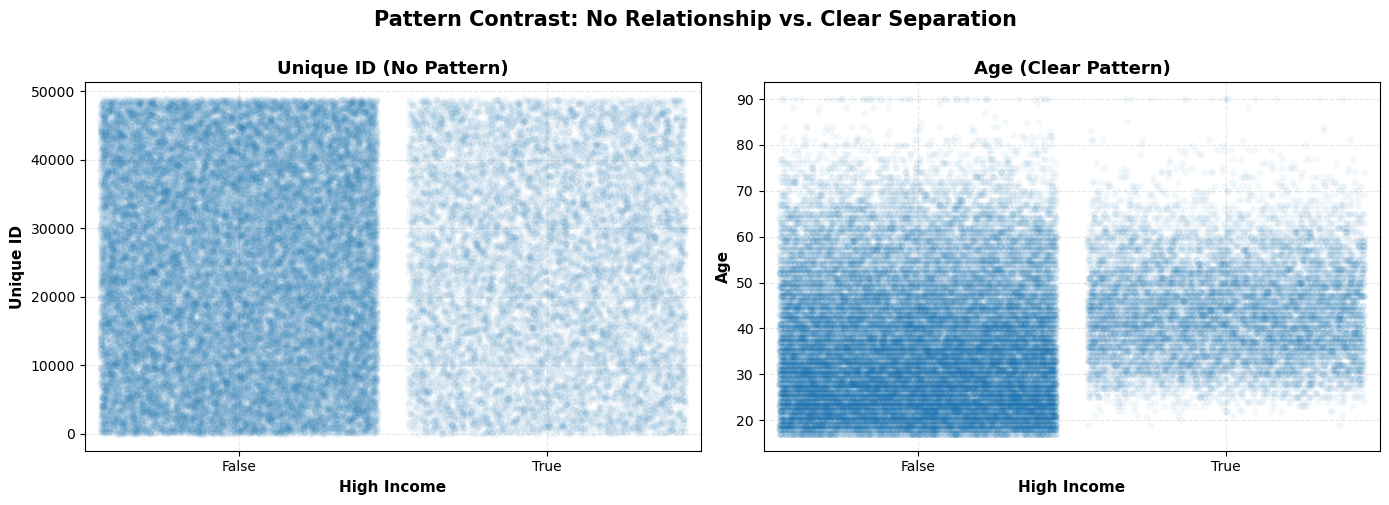

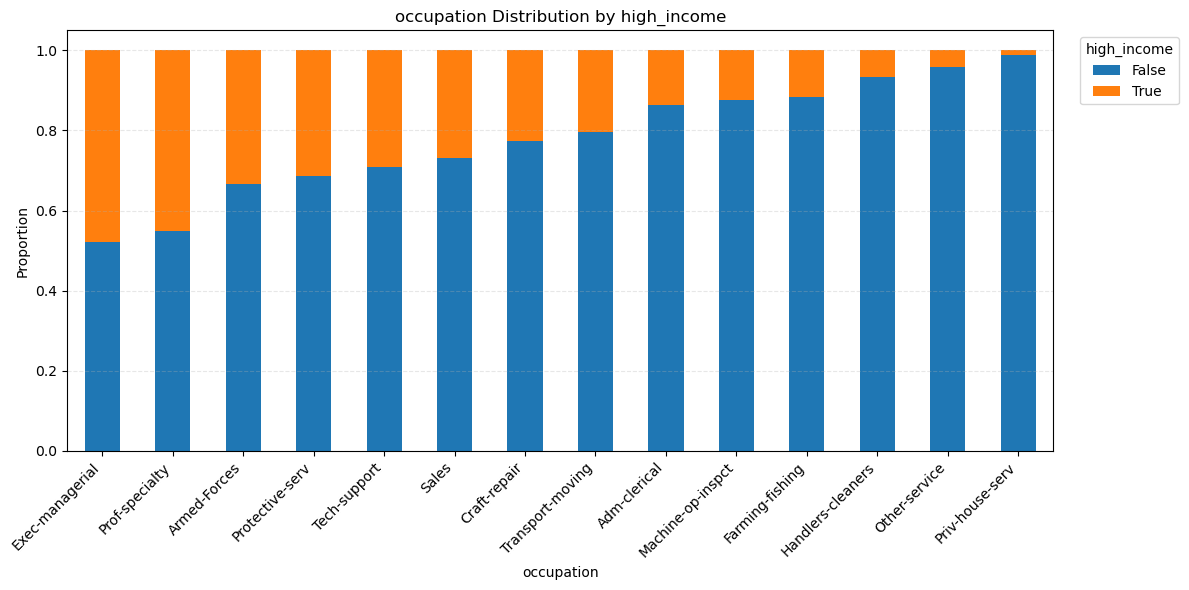

In [4]:
from notebooks.visualisations import correlation_compare, occupation_correlation

correlation_compare.correlation_compare(df_clean)
occupation_correlation.occupation_correlation(df_clean)


### Train-Test Split Strategy

**Split Methodology**:
- Method: Hash-based splitting on unique_id
- Ratio: 80% train, 20% test
- Reproducibility: Hash function ensures same split across runs

**Rationale**:
- Hash-based splitting avoids random seed dependence
- Same individual always in same set (no data leakage)
- 80/20 provides sufficient training data while maintaining robust test set

### Feature Engineering Approach

TODO

## Modelling

### Model Selection

Two complementary approaches were selected:

1. Generalized Linear Model (GLM) - Logistic Regression
2. LightGBM (Gradient Boosting Machine)

**Why GLM?**:

- Interpretability: Coefficients show linear relationship between each feature and the target
- Baseline: Establishes performance floor. Simpler models preferred if comparable
- Probabilistic: Natural probability outputs for binary classification
- Fast Training: Scales well to large datasets
- Assumptions: Appropriate if relationships are approximately linear

**Why LGBM?**:

- Non-linear Relationships: Captures complex interactions between features
- Feature Interactions: Automatically learns combinations without manual engineering
- Robust: Handles missing values, outliers, and mixed feature types well
- Performance: Generally highly accurate, in comparisson to GLM and other boosting models
- Feature Importance: Provides interpretable feature rankings

### Evaluation Approach

#### Metric Selection

Metric Selection and Rationale:

| Metric | Why Important | Interpretation |
|--------|---------------|----------------|
| **Accuracy** | Overall correctness | % of correct predictions |
| **Precision** | Minimize false positives | Of predicted high-income, % actually high-income |
| **Recall** | Minimize false negatives | Of actual high-income, % correctly identified |
| **F1-Score** | Balance precision/recall | Harmonic mean; useful for imbalanced data |
| **ROC-AUC** | Ranking quality | Probability of ranking random positive > negative |
| **Log Loss** | Probability calibration | Penalizes confident wrong predictions |


**Primary Metric/s**: It depends on the exact business question. For example, charity donor prospecting will likley want a model with high **Precision** and **Log Loss**, so that they can target people that are most likley to have high income. Another example would be for government public policy that is keen to understand where both high income and not high income people are, **Accuracy** would be the most valuable metric to them.

#### Evaluation Strategy

- Train Set: Used for model training and hyperparameter tuning (with cross-validation)
- Test Set: Held out for final evaluation only (no model selection on test set)
- Cross-Validation: 5-fold stratified CV during hyperparameter tuning
    - Ensures robust parameter selection
    - Reduces overfitting to single validation split
    - Maintains class balance in each fold
- Preventing Overfitting:
    - Separate train/test split (no test set leakage)
    - Cross-validation for hyperparameter selection
    - Regularization in GLM (L1/L2 penalty)
    - Early stopping consideration in LGBM

### Hyperparameter Tuning

#### GLM Tuning

**Parameters selected**:
| Parameter | Search Space | Purpose | Baseline Value | Tuned Value |
|-----------|--------------|---------|----------------|----------------|
| `alpha` | 10^-4 to 10^-1 (log-uniform) | Regularization strength (higher = more regularization) | 0.0001 | **0.000861** |
| `l1_ratio` | 0 to 1 (uniform) | Balance between L1 (Lasso) and L2 (Ridge) penalty | 0.15 | **0.520** |

**Tuning Process:**
- **Method:** Randomized search (more efficient than grid search for continuous parameters)
- **Iterations:** 50 random combinations sampled
- **Cross-Validation:** 5-fold stratified ensures robust evaluation
- **Search Strategy:** Log-uniform for `alpha` (covers multiple orders of magnitude)

#### LGBM Tuning

**Parameters selected**:
| Parameter | Search Space | Purpose | Baseline Value | Tuned Value |
|-----------|--------------|---------|----------------|----------------|
| `learning_rate` | 0.01 to 0.2 (log-uniform) | Controls step size in gradient descent | 0.1 | **0.158** |
| `n_estimators` | 50 to 200 (integer) | Number of boosting rounds (trees) | 100 | **89** |
| `num_leaves` | 10 to 60 (integer) | Maximum leaves per tree (complexity) | 31 | **30** |
| `min_child_weight` | 0.0001 to 0.002 (log-uniform) | Minimum sum of instance weight in leaf (regularization) | 0.001 | **0.00013** |

**Tuning Process:**
- **Method:** Randomized search (efficient for large search space)
- **Iterations:** 20 combinations (LGBM slower to train than GLM)
- **Cross-Validation:** 5-fold stratified


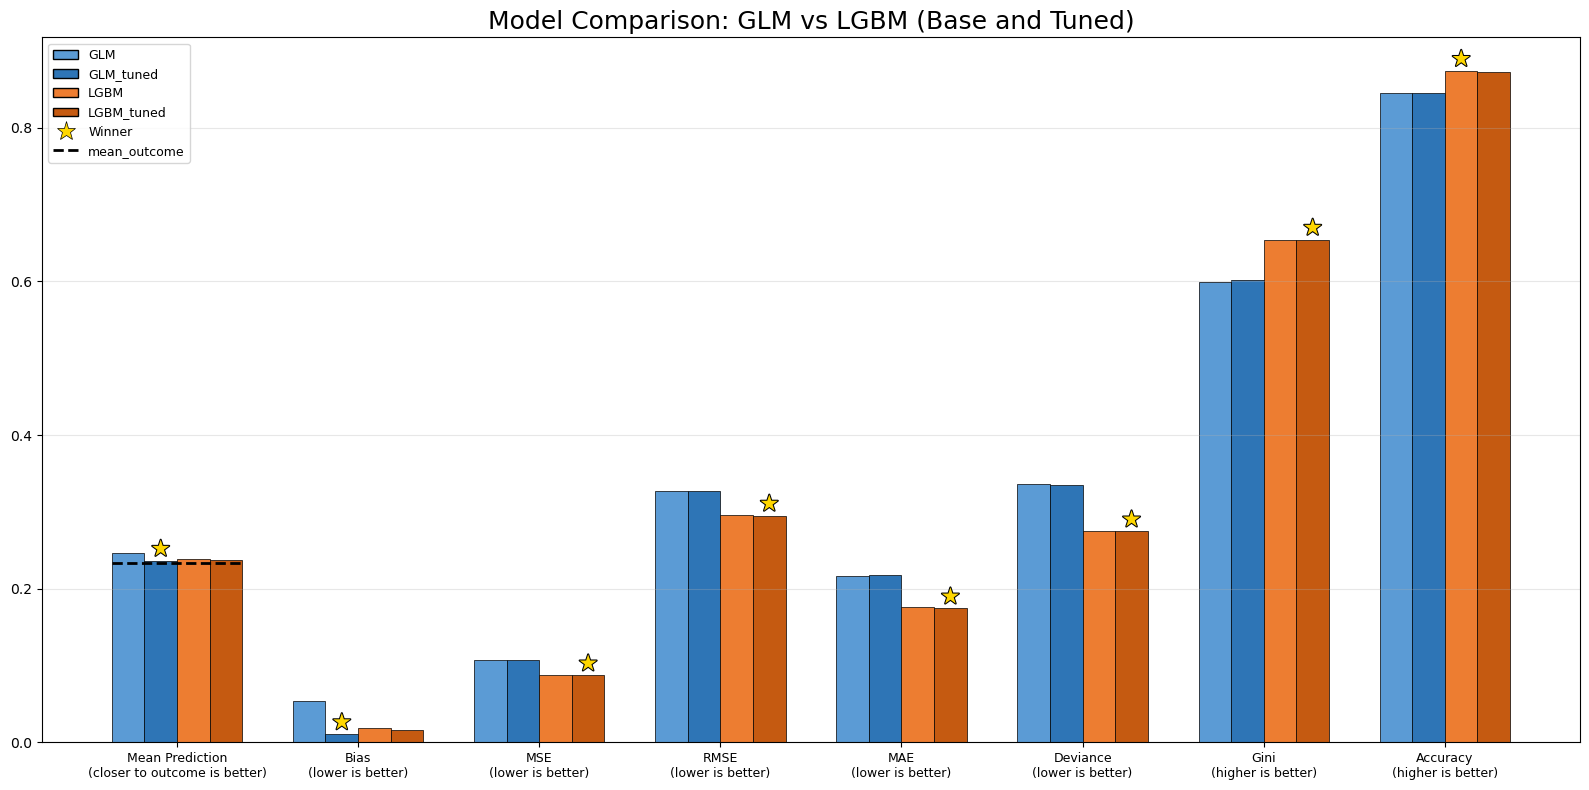

In [5]:
from notebooks.visualisations import model_comparison

model_comparison.model_comparison()

**Performance Interpretation:**

**LGBM outperforms GLM across nearly all metrics.** The tuned LGBM achieves lower error rates (MSE: 0.087 vs 0.107, MAE: 0.174 vs 0.217) and better discriminative ability (Gini: 0.654 vs 0.602). Accuracy follows the same pattern at 87.3% vs 84.6%.

**The most striking result is GLM's bias reduction after tuning.** Bias dropped from 0.053 to 0.011 (80% improvement). This means the baseline GLM was systematically over-predicting (mean prediction 0.246 vs actual 0.234), and tuning corrected this calibration issue. However, other GLM metrics barely changed, suggesting the tuning primarily improved calibration rather than overall predictive power.

**LGBM showed modest gains from tuning**, with small improvements across metrics. This indicates the baseline LGBM hyperparameters were already near-optimal for this dataset, while GLM benefited more substantially from parameter adjustment.

Given the general improvements in the tuned models, I shall only focus on these models moving forward.

**Classification Performance Analysis**

Classification performance matters because it reveals not just overall accuracy, but where the model is accurate, i.e. false positives vs false negatives.

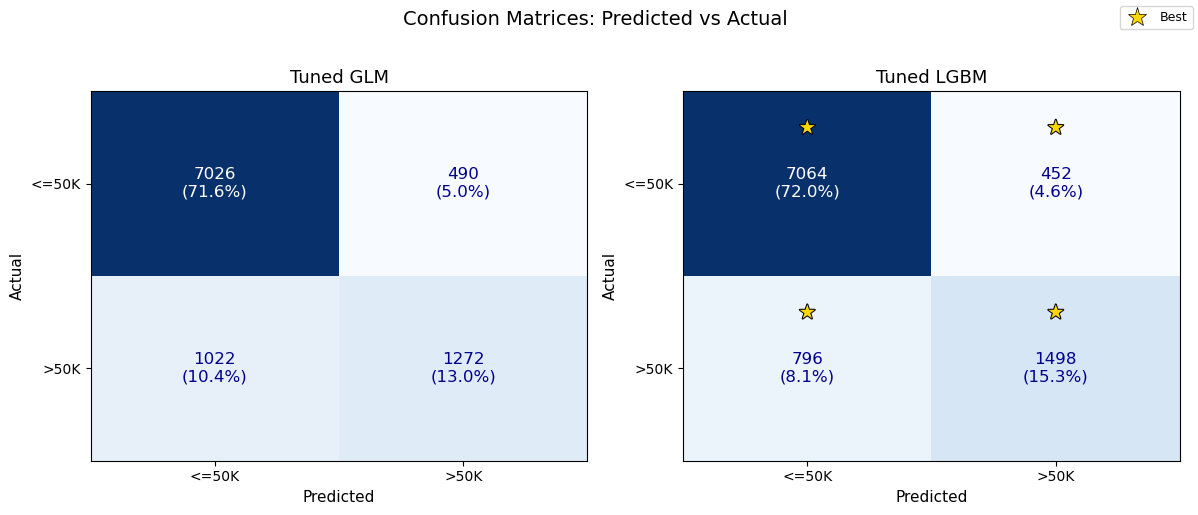

In [6]:
from notebooks.visualisations import confusion_matrix

confusion_matrix.confusion_matrix()

**Confusion Matrix Insights**:

LGBM beats GLM across all metrics in the classification analysis.

Given LGBM is better at avoiding false positives and false negatives, there is no need to consider which is more important. However, if one model was better at false positives and the other better at false negatives, we would need to consider the business implications to determine which model would be prefered.

**Feature Importance Comparison**

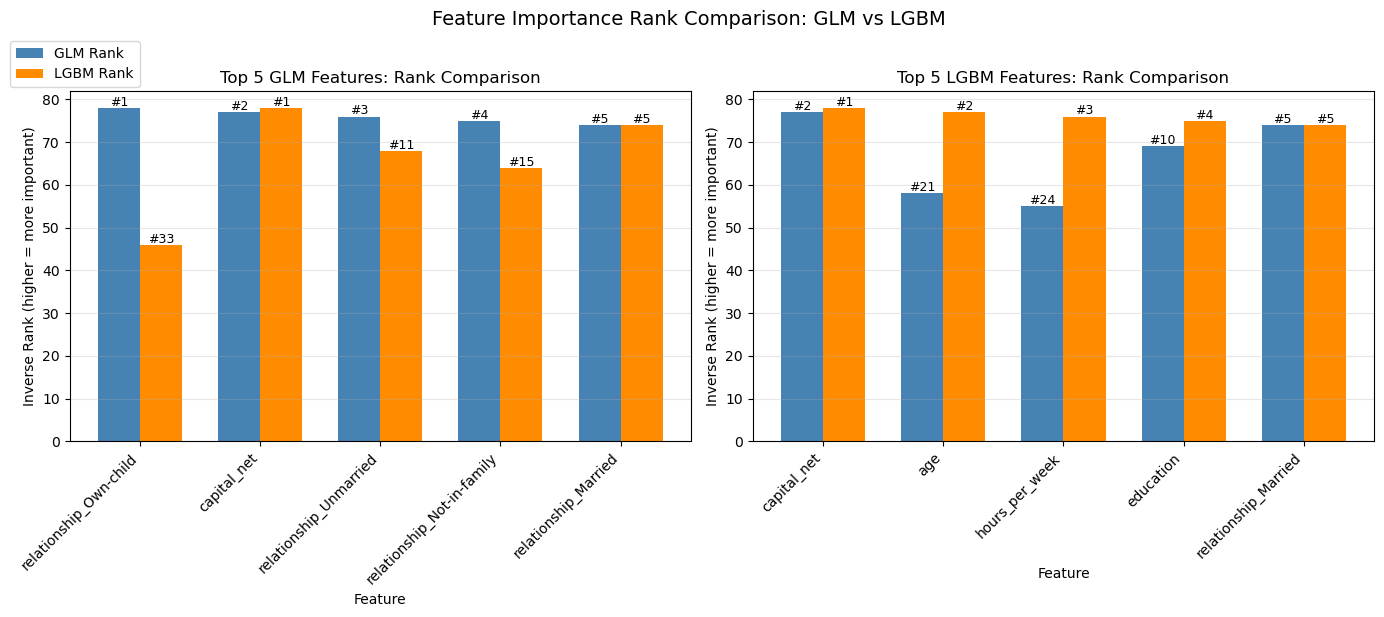

In [7]:
from notebooks.visualisations import feature_importance_rank

feature_importance_rank.feature_importance_rank()

**Feature Importance Insights**

Interestingly, the Feature Importance chart shows that the GLM model and LGBM model can rate particualr features very similarly, in the case of capital_net it's no.2 for GLM and no.1 for LGBM, as well as very differently, in the case of relationship = 'Own-child' it's no.1 for GLM and no.33 for LGBM. This highlights the fundamental differences in how these models learn patterns from data. GLM relies on linear relationships and assigns high importance to features with strong individual correlations to the target, whereas LGBM captures complex non-linear interactions and may find a feature redundant if its predictive power is already captured by other variables. The discrepancy with 'Own-child' suggests that while this relationship status has a clear association with income, LGBM likely extracts the same signal through combinations of other features like age and hours worked.

**Partial Dependence Analysis**

The four Partial Dependence charts below may seem exissive, however, I do think they are all valuable in understanding both how GLM and LGBM models work generally, and the specific insights they highlight for this dataset.


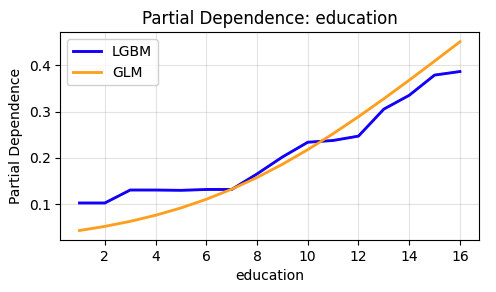

In [8]:
from IPython.display import display, Image

image_path = src_directory / "notebooks" / "visualisations" / "images"

display(Image(filename=image_path / "partial_dependence_education.png"))

**Partial Dependence: Education**

Education appears to be approximatley linear in both models. It's a good example of not needing a particularly powerful model like LGBM to capture this relationship, a simple regression model like GLM does the job. Furthermore, the story that both models say makes intuitive sense, since it is generally understood that the more education you have the more likley you are to earn a higher paying job.

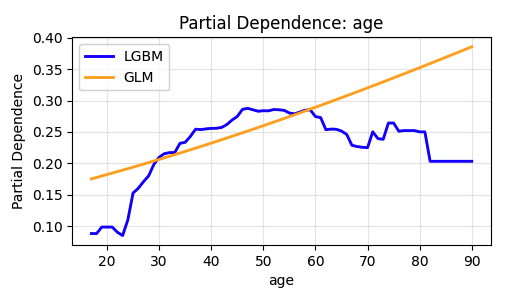

In [9]:
display(Image(filename=image_path / "partial_dependence_age.png"))

**Partial Dependence: Age**

Age is a different story. GLM is clearly faily to capture the nuance of the data, which LGBM does capture. Intuitivley, it makes sense that income peaks at around middle-age.  

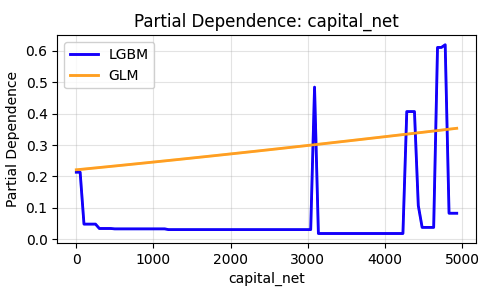

In [10]:
display(Image(filename=image_path / "partial_dependence_capital_net.png"))

**Partial Dependence: Net Capital**

Net Capital offers us another interesting story. While GLM predicts a straightforward linear relationship between net capital and high income, an intuitively reasonable assumption, LGBM exhibits peculiar behavior. It assigns very low probability of high income at $3,500 net capital but very high probability at $3,000.

This anomaly likely comes from limitations in the data. The vast majority of observations have zero net capital, leaving sparse data for model training at other values. An alternative reason could be a genuine quirk in the 1994 US dataset. Perhaps a policy or event that year resulted in many high earners receiving exactly $3,000 in net capital.

Regardless of cause, this example highlights LGBM's remarkable ability to detect patterns at specific values. While this can lead to false patterns when data is limited, you can imagine it being extremely useful for tasks like fraud detection, where fraudsters might consistently use certain, seemingly-random figures that would be hard for humans to notice.

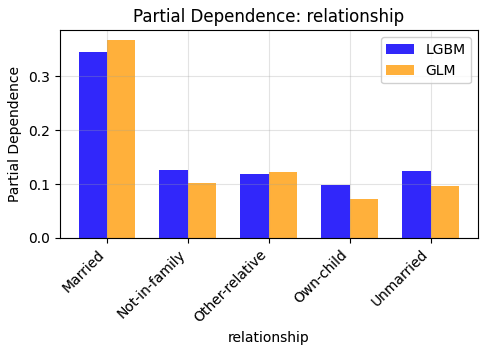

In [11]:
display(Image(filename=image_path / "partial_dependence_relationship.png"))

**Partial Dependence: Relationship**

Our final story in the Partial Dependence analysis comes from the Relationship field. Unlike the other features show above, this is a categorical feature. LGBM and GLM give approximatley similar values for each of the Relationship categories.

## Future Improvements & Business Considerations

### Dataset Improvements

Although this dataset was valuable in predicting high income, there could be improvements. I list a few below:

- Additional features that would likley make our predictions more accurate:
    - Geographic granularity
        - State/city of residence (not just country)
        - Cost of living index for location
        - Local unemployment rate
    - Detailed education information
        - Specific school/university attended
        - Subject/s speciallised at university
    - Company Information:
        - Industry sector employed at
        - Company size (small business vs Fortune 500)
        - Years at current employer

- Target variable
    - Binary >$50k or <=$50k was the only income metric avaialble in the dataset
    - Although a $50,000 income at the time of the Census was quite a high income, I might have adjusted this thershold slightly has there been data available to do so
    - It may have been more business relevant to predict the exact income of an individual, rather than the binary prediction. To do this I would need the dataset to be enhanced with exact incomes of individuals

- Cleaner data
    - Though I was able to clean the data pretty well, there were some issues that could not be fixed:
        - Missing data in occuption and native-country
        - Unknown unknowns. It's possible that there were more issues with the data that I failed to find

- More data
    - Although the sample size was relativley large, it was sparse for some edge cases, like non-zero net capital individuals. As a result, the LGBM model likley overfitted for non-zero net capital individuals
    - The data came from a relativley old source, 1994 Census. Additonal data from other census years would provide more confidence in the results being general, rather than 1994 specific

- Relevant data
    - Most business cases for predicting high income are likley to be interested in predicting high income today, or in the near future
        - The most recent Census would be a much stronger data source for achieving this
        - Multiple Censuses might help in spotting time trends, to predict future high incomers
    - Organisations based in the UK would prefer a data source that originated from people in the UK, not the US

### Modelling Improvements

#### Other Models

Only two models were used in this analysis, however, there is a vast array of other alternatives. For example:

- **Alternative for GLM: Generalized Additive Models (GAMs)**
    - *What:* This model can be seen as an extension of the GLM model, where we also allow for non-linear functions
    - *Why good for this problem:* Allows for non-linear functions for specific features, this is clearly an improvement on our GLM for features like age; still good degree of interpretability due to additivity
    - *Downsides:* Overfitting is more of a risk than GLM; Like GLM, we still have to pre-define potential interactions between features

- **Alternative for LGBM: XGBoost**
    - *What:* Another gradient boosint model, like LGBM; XGBoost uses depth-wise growth, vs LGBM's tree-wise growth
    - *Why good for this problem:* Would naturally handle the non-linear age-income relationship and interactions between education/occupation; robust to the outliers in capital_net; can handles the mix of numeric and categorical features
    - *Downsides:* Typically less accurate than LGBM on tabular data like this; slower training and larger model size

**Alternative vs GLM/LGBM:**

- **GAM likley beats GLM:** For our dataset, with a number of non-linear features, it's likely a GAM model would be preffered over our GLM model. I'd recommend trying GAM on this dataset for furture research
- **LGBM likley beats XGBoost:** The growth strategy used by LGBM tends to outperform XGBoost's method. Perhaps a more interesting experiment for future research would be a totally differnt style of model, like a neural network, though this dataset's 48k rows might be too small for such a model

#### Advanced Feature Engineering

With more time I would have liked to delve into some of the following feature engineering techniques.

- **Interaction between features**
    - Education × Occupation (PhD in healthcare vs PhD in academia)
    - Age × Education (early career PhD vs late career PhD)
    - Hours_per_week × Occupation (overtime matters differently by job)
    - Implementation: Use PolynomialFeatures or manual feature creation

- **Polynomial anlysis of features**
    - Capital_net transformations (log, sqrt) for skewed distribution
    - Could use sklearn's PolynomialFeatures() function

- **Binning of features**
    - Age groups (young adult, mid-career, pre-retirement)
    - Hours worked categories (part-time, full-time, overtime)
    - This may help capture non-linear effects more explicitly, especially with GLM

#### Hyperparameter Tuning Extensions

Sklearn offers many other options for tuning GLM and LGBM models that I did not touch on. Had I, perhaps I would have seen a real improvement in the tuned models vs baseline models.

### Critical Business Considerations

As mentioned previously, access to more relevant census data would be much more valuable for most organisations interested in this sort of analysis.

Moving beyond this limitation, one has to wonder how organisations can deploy such a model. Detailed enough census data is difficult to access (hence why I use 1994 US census). In the real business world I'd expect this model to be a sort of toy model, used as part of the evaluation of whether significant investment towards a model that can be productionalised is worth it.

On the other hand, perhaps productionalization of a model isn't required for this model/anlaysis to be deemed a success. It is possible that the insights generated, e.g. feature importance and partial dependence, is where the value lays. For example, a charity may update its potential donor wealth assessment because if this.

It's important to keep in mind that the whole reason for data science in business is to generate business value. If an organisation is interested in the insights of a data science project, rather than deploying a model into production, it makes little sense to select a model with high flexibility but low interpretability.